In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib.colors import ListedColormap
import statsmodels.api as sm
import statsmodels.formula.api as smf
from irt import *
data_path = '/llmthonskdir/felipe/download_openllmlb/'

def filter(s):
    try:s = s.split("/")[1]
    except: s = s
    try:s = s.split("__")[1]
    except: s = s
    return s.lower().replace("-hf","").replace("_","").replace("-","")
    
def search(s, s_list):
    scores = [fuzz.token_sort_ratio(filter(s), filter(s_try)) for s_try in s_list]
    return [s_list[np.argmax(scores)], np.max(scores)]

In [2]:
scenarios = ['harness_arc_challenge_25', 'harness_gsm8k_5', 'harness_hellaswag_10', 'harness_truthfulqa_mc_0', 'harness_winogrande_5', 'harness_hendrycksTest_abstract_algebra_5', 'harness_hendrycksTest_anatomy_5', 'harness_hendrycksTest_astronomy_5', 'harness_hendrycksTest_business_ethics_5', 'harness_hendrycksTest_clinical_knowledge_5', 'harness_hendrycksTest_college_biology_5', 'harness_hendrycksTest_college_chemistry_5', 'harness_hendrycksTest_college_computer_science_5', 'harness_hendrycksTest_college_mathematics_5', 'harness_hendrycksTest_college_medicine_5', 'harness_hendrycksTest_college_physics_5', 'harness_hendrycksTest_computer_security_5', 'harness_hendrycksTest_conceptual_physics_5', 'harness_hendrycksTest_econometrics_5', 'harness_hendrycksTest_electrical_engineering_5', 'harness_hendrycksTest_elementary_mathematics_5', 'harness_hendrycksTest_formal_logic_5', 'harness_hendrycksTest_global_facts_5', 'harness_hendrycksTest_high_school_biology_5', 'harness_hendrycksTest_high_school_chemistry_5', 'harness_hendrycksTest_high_school_computer_science_5', 'harness_hendrycksTest_high_school_european_history_5', 'harness_hendrycksTest_high_school_geography_5', 'harness_hendrycksTest_high_school_government_and_politics_5', 'harness_hendrycksTest_high_school_macroeconomics_5', 'harness_hendrycksTest_high_school_mathematics_5', 'harness_hendrycksTest_high_school_microeconomics_5', 'harness_hendrycksTest_high_school_physics_5', 'harness_hendrycksTest_high_school_psychology_5', 'harness_hendrycksTest_high_school_statistics_5', 'harness_hendrycksTest_high_school_us_history_5', 'harness_hendrycksTest_high_school_world_history_5', 'harness_hendrycksTest_human_aging_5', 'harness_hendrycksTest_human_sexuality_5', 'harness_hendrycksTest_international_law_5', 'harness_hendrycksTest_jurisprudence_5', 'harness_hendrycksTest_logical_fallacies_5', 'harness_hendrycksTest_machine_learning_5', 'harness_hendrycksTest_management_5', 'harness_hendrycksTest_marketing_5', 'harness_hendrycksTest_medical_genetics_5', 'harness_hendrycksTest_miscellaneous_5', 'harness_hendrycksTest_moral_disputes_5', 'harness_hendrycksTest_moral_scenarios_5', 'harness_hendrycksTest_nutrition_5', 'harness_hendrycksTest_philosophy_5', 'harness_hendrycksTest_prehistory_5', 'harness_hendrycksTest_professional_accounting_5', 'harness_hendrycksTest_professional_law_5', 'harness_hendrycksTest_professional_medicine_5', 'harness_hendrycksTest_professional_psychology_5', 'harness_hendrycksTest_public_relations_5', 'harness_hendrycksTest_security_studies_5', 'harness_hendrycksTest_sociology_5', 'harness_hendrycksTest_us_foreign_policy_5', 'harness_hendrycksTest_virology_5', 'harness_hendrycksTest_world_religions_5']

In [3]:
scenario = 'harness_hellaswag_10'

In [16]:
#for scenario in scenarios:

###
with open('lb.pickle', 'rb') as handle:
    lb_data1 = pickle.load(handle)
with open(data_path+'scaling_laws/old_leaderboard_processed_20240630.pickle', 'rb') as handle:
    lb_data2 = pickle.load(handle)
scaling_base = pd.read_csv(data_path+'scaling_laws/base_llm_benchmark_eval.csv')
scaling_inst = pd.read_csv(data_path+'scaling_laws/instruct_llm_benchmark_eval.csv')
scaling_data = pd.concat((scaling_base, scaling_inst))

In [17]:
###
models_irt_train = lb_data1['models']
models_irt_train = [filter(m) for m in models_irt_train]
models = lb_data2[scenario]['models']
models = [filter(m) for m in models]
scaling_models = list(scaling_data.Model)
scaling_models = [filter(m) for m in scaling_models]
ind = [i for i,m in enumerate(models_irt_train) if m not in models]

In [7]:
irt = IRT([1])
irt.fit(lb_data1['data'][scenario]['correctness'].T[ind], verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

epoch=0, d=1, train loss=0.20586, val loss=0.19954, val acc=0.92641
epoch=1, d=1, train loss=0.18005, val loss=0.18127, val acc=0.92659
epoch=2, d=1, train loss=0.17697, val loss=0.17994, val acc=0.92673
epoch=3, d=1, train loss=0.17509, val loss=0.17879, val acc=0.92673
epoch=4, d=1, train loss=0.17388, val loss=0.17813, val acc=0.92684


In [8]:
Y = lb_data2[scenario]['correctness']
theta = irt.fit_theta(Y, list(range(Y.shape[1]))).squeeze()

In [18]:
scaling_thetas = []
for s in scaling_models:
    if np.sum(np.array(models)==s)>0:
        scaling_thetas.append(theta[np.argmax(np.array(models)==s)])
    else:
        scaling_thetas.append(np.nan)       

In [19]:
###
scaling_data['theta'] = scaling_thetas
scaling_data = scaling_data.loc[~np.isnan(scaling_data.theta)]
scaling_data = scaling_data.loc[~np.array(np.isnan(scaling_data.loc[:,['FLOPs (1E21)']])).squeeze()]
scaling_data['logFLOPs'] = np.log2(scaling_data.loc[:,['FLOPs (1E21)']])
scaling_data = scaling_data.loc[:,['Model Family', 'logFLOPs', 'theta', 'Model Size (B)']]
scaling_data = scaling_data.rename(columns={'Model Family': "family"})
scaling_data = scaling_data.groupby('family').filter(lambda x: len(x) > 2)
scaling_data = scaling_data.sort_values(by=['family', 'logFLOPs'])

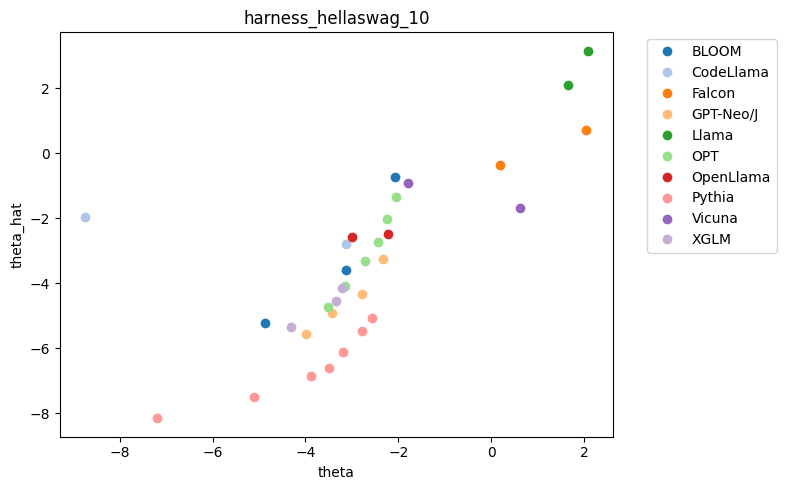

In [20]:
###
families = np.unique(scaling_data.family).tolist()
cmap = ListedColormap(plt.get_cmap('tab20').colors[:len(families)])  # Ensure unique colors

preds = []
trues = []
plt.figure(figsize=(8, 5))

for i, fam in enumerate(families):
    test_fam = [fam]
    train_fam = [f for f in families if f not in test_fam]
    test_ind = np.array([f in test_fam for f in scaling_data.family])
    train_ind = ~np.array(test_ind)
    test_data = scaling_data.loc[test_ind]
    train_data = scaling_data.loc[train_ind]
    
    mod = smf.ols(formula='theta ~ logFLOPs + family - 1', data=train_data)
    mod = mod.fit()
    
    intercept = np.array(test_data.theta)[0] - (mod.params['logFLOPs']*np.array(test_data.logFLOPs))[0]
    preds = np.array(intercept + mod.params['logFLOPs']*np.array(test_data.logFLOPs)).tolist()[1:]
    trues = np.array(test_data.theta).tolist()[1:]
    
    plt.plot(trues, preds, 'o', label=test_fam[0], color=cmap(i))

#min_val = -10
#max_val = 10
#plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('theta')
plt.ylabel('theta_hat')
plt.title(scenario)
plt.tight_layout()
plt.show()